# DATA PROCESSING

Import libraries

In [13]:
# For Path handling
from pathlib import Path

# For General Data Wrangling and Calculations
import pandas as pd
import numpy as np

# For NLP
import nltk

# For stop word filtering
#nltk.download("stopwords")
from nltk.corpus import stopwords

# For tokenizing
from nltk.tokenize import RegexpTokenizer, word_tokenize
#nltk.download('punkt_tab')
#nltk.download('wordnet')

# For lemmatizing
from nltk.stem import WordNetLemmatizer

# For TF-IDF transformation
from sklearn.feature_extraction.text import TfidfVectorizer

# For Word Embedding
import sent2vec

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# For UMAP
from umap import UMAP
%matplotlib inline

# To save files
from scipy.sparse import save_npz

Load input files

In [3]:
# Train data path
train_df = Path("../data/Raw/medical_tc_train.csv")
# Test data path
test_df = Path("../data/Raw/medical_tc_test.csv")
# Labels path
labels_df = Path("../data/Raw/medical_tc_labels.csv")

# Open train data
train_df = pd.read_csv(train_df)
test_df = pd.read_csv(test_df)
labels_df = pd.read_csv(labels_df)

# Add Labels to Training and Testing sets
train_df = pd.merge(train_df,labels_df, how = "left", on = "condition_label")
test_df = pd.merge(test_df,labels_df, how = "left", on = "condition_label")

# Concatenate dataframes for general dataset exploration
full_df = pd.concat([train_df, test_df])

# Visualize top 10 rows
print(f"Training set (length: {len(train_df)}):\n", train_df.head(10))
print(f"Test set (length: {len(test_df)}):\n", test_df.head(10))
print(f"Labels (length: {len(labels_df)}):\n", labels_df.head(10))

Training set (length: 11550):
    condition_label                                   medical_abstract  \
0                5  Tissue changes around loose prostheses. A cani...   
1                1  Neuropeptide Y and neuron-specific enolase lev...   
2                2  Sexually transmitted diseases of the colon, re...   
3                1  Lipolytic factors associated with murine and h...   
4                3  Does carotid restenosis predict an increased r...   
5                3  The shoulder in multiple epiphyseal dysplasia....   
6                2  The management of postoperative chylous ascite...   
7                4  Pharmacomechanical thrombolysis and angioplast...   
8                5  Color Doppler diagnosis of mechanical prosthet...   
9                5  Noninvasive diagnosis of right-sided extracard...   

                    condition_name  
0  general pathological conditions  
1                        neoplasms  
2        digestive system diseases  
3                

Add labels to train data for posterior visualization

In [4]:
train_df = pd.merge(train_df,labels_df, how = "left", on = "condition_label")
test_df = pd.merge(test_df,labels_df, how = "left", on = "condition_label")

# Visualize top rows
train_df.head()

,condition_label,medical_abstract,condition_name_x,condition_name_y
0,5,Tissue changes around loose prostheses. A cani...,general pathological conditions,general pathological conditions
1,1,Neuropeptide Y and neuron-specific enolase lev...,neoplasms,neoplasms
2,2,"Sexually transmitted diseases of the colon, re...",digestive system diseases,digestive system diseases
3,1,Lipolytic factors associated with murine and h...,neoplasms,neoplasms
4,3,Does carotid restenosis predict an increased r...,nervous system diseases,nervous system diseases


## 1. Lower text and remove stopwords / punctuation
Stop words are frequently found in all kind of texts since thay contribute to the sentence structure and meaning. However, they should be removed (depending on the analysis) to reduce the noise they might produce. Also, after removing them we will have a reduced text amount to process (data size reduction) and an improved performance. Besides, to have a more homogenous text it is necessary to lower all the text and remove punctuations.

In [5]:
# Define stop words
stop_words = set(stopwords.words("english"))

Define function to remove stop words from data

In [6]:
def remove_stopwords_punctutation(data_df):

    # Define tokenizer
    tokenizer = RegexpTokenizer(r"\w+")
    
    # Initialize loop to iterate through
    for i, row in data_df.iterrows():
    
        # Get cell
        text = row["medical_abstract"]
    
        # Check if the cell contains text
        if isinstance(text, str):
        
            # Lower and tokenize text
            tokens = tokenizer.tokenize(text.lower())
        
            # Remove stop words
            tokens_clean = [token for token in tokens if token not in stop_words]
        
            # Detokenize text
            cleaned_sentence = " ".join(tokens_clean)

            # Save processed text
            data_df.loc[i, "medical_abstract"] = cleaned_sentence

    # Return cleaned text
    return data_df

Clean text

In [7]:
# Train data
train_clean_df = remove_stopwords_punctutation(train_df)
# Test data
test_clean_df = remove_stopwords_punctutation(test_df.drop(columns = ["condition_label"]))
# We drop the condition_label to not have it into account during the data exploration of data to be classified.
# Full data
full_clean_df = remove_stopwords_punctutation(full_df.drop(columns = ["condition_label"]))

# Visualize top rows
#train_clean_df.head()
test_clean_df.head()

,medical_abstract,condition_name_x,condition_name_y
0,obstructive sleep apnea following topical orop...,nervous system diseases,nervous system diseases
1,neutrophil function pyogenic infections bone m...,general pathological conditions,general pathological conditions
2,phase ii study combined methotrexate teniposid...,general pathological conditions,general pathological conditions
3,flow cytometric dna analysis parathyroid tumor...,neoplasms,neoplasms
4,paraneoplastic vasculitic neuropathy treatable...,cardiovascular diseases,cardiovascular diseases


## 2. Lemmatize
Lemmatizing reduce the words to their core meaning. For example, for words such as "do", "doing" and "done", lemmatizing will substitute them by "do", their core word. This process again reduces the amount of text to process (amount of total unique words), making the procesing more efficient.

Define function to lemmatize data

In [8]:
def lemmatize_data(data_df):

    # Define lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Define counter to count sentences that do not change with lemmatization
    counter = 0
    
    # Initialize loop to iterate through
    for i, row in data_df.iterrows():
    
        # Get cell
        text = row["medical_abstract"]
    
        # Check if the cell contains text
        if isinstance(text, str):
        
            # Lower and tokenize text
            tokens = word_tokenize(text)
        
            # Lemmatize
            lemmas = [lemmatizer.lemmatize(token) for token in tokens]
        
            # Detokenize text
            lemma_sentence = " ".join(lemmas)

            # Save processed text
            data_df.loc[i, "medical_abstract"] = lemma_sentence

            # Check if sentences are the same
            if text == lemma_sentence:
                counter += 1

    # Report the amount of lemmatized sentences
    if counter == len(data_df):
        print(f"All medical abstracts' text have remained the same after lemmatization: {counter}/{len(data_df)}")

        # Return cleaned text
        return data_df
    
    elif counter < len(data_df):
        print(f"Some sentences have been lemmatized: {counter}/{len(data_df)}")

        # Return cleaned text
        return data_df

    else:
        raise Exception(f"Something went wrong: {counter}/{len(data_df)}")

Lemmatize text

In [9]:
# Train data
train_lemma_df = lemmatize_data(train_clean_df)
# Test data
test_lemma_df = lemmatize_data(test_clean_df)

# All data
full_lemma_df = lemmatize_data(full_clean_df)

# Visualize top rows
#train_lemma_df.head()
test_lemma_df.head()

Some sentences have been lemmatized: 106/11550
Some sentences have been lemmatized: 24/2888
Some sentences have been lemmatized: 131/14438


,medical_abstract,condition_name_x,condition_name_y
0,obstructive sleep apnea following topical orop...,nervous system diseases,nervous system diseases
1,neutrophil function pyogenic infection bone ma...,general pathological conditions,general pathological conditions
2,phase ii study combined methotrexate teniposid...,general pathological conditions,general pathological conditions
3,flow cytometric dna analysis parathyroid tumor...,neoplasms,neoplasms
4,paraneoplastic vasculitic neuropathy treatable...,cardiovascular diseases,cardiovascular diseases


## 3. Text Vectorization
Text vectorization is converting text into numeric data, by transforming the textual data into vectors.
### 3.1. Term Frequency-Inverse Document Frequency (TF-IDF)
The TF-IDF technique measured the relevance of a term present in a document (medical abstract) within a larger corpus (the entire collection). To calculate the TF-IDF the following formula was applied:
$$
\text{TF-IDF} = \frac{n}{d} \times \log_{10} \frac{N}{n}
$$
Where:
- \(n\): The frequency of the term in the document.
- \(d\): The total number of terms in the document.
- \(N\): The total number of documents in the corpus.
- \(n_t\): The number of documents that contain the term.
- (TF): Term Frequency, calculated as:
   $$\frac{n}{d}$$
- (IDF): Inverse Document Frequency, calculated as:
  $$\log_{10} \frac{N}{n_t}$$

Define function for performing the TF-IDF tranformation

In [10]:
def tfidf_transformation(data_df):

    # Define corpus
    corpus = data_df["medical_abstract"]

    # Define and instance of the TF-ID vectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform corpus into a matrix containing TF-IDF
    matrix = vectorizer.fit_transform(corpus)

    # Return matrix
    return matrix

Transform text to vector using TF-IDF tranformation

In [22]:
# Full lemmatized data to mantain the same vector size
full_lem_tdidf = tfidf_transformation(full_lemma_df)

train_tfidf = full_lem_tdidf[:11550]
test_tfidf = full_lem_tdidf[11550:]

### 3.2. Sentence Embedding using BioSentVec
Sentence embedding is a language modelling technique that converts sentences to vectors of real numbers. This technique represents a sentence in vector space with multiple dimensions. In this case, we will use a model called BioSentVec, which is a pre-trained embedding model for biomedical sentences. It was trained on PubMed and MIMIC-III texts.

Load model

In [12]:
# Define the model location
model_path = "../model/BioSentVec_PubMed_MIMICIII-bigram_d700.bin"
# Define the model instance
model = sent2vec.Sent2vecModel()

# Load model
try:
    model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


Define function to transform sentence to vector using BioSentVec model

In [13]:
def sentence_to_vector(data_df):
    
    # Initialize an empty list to store the sentence vectors
    vectors = []
    
    # Initialize loop to iterate through
    for i, row in data_df.iterrows():
    
        # Get cell
        text = row["medical_abstract"]
    
        # Check if the cell contains text
        if isinstance(text, str):

            # Retrieve vector from sentence
            sentence_vector = model.embed_sentence(text)

            # Append the vector to the list
            vectors.append(sentence_vector[0])

    # Return array with sentences' vectors
    return np.array(vectors)

Transform sentences to vectors using BioSentVec model

In [14]:
# Training lemmatized data
train_lem_vec = sentence_to_vector(train_lemma_df)
# Testing lemmatized data
test_lem_vec = sentence_to_vector(test_lemma_df)

## 4. Save Processed Data
Since the data processing is the limitant step, specially the sent2vec transformation (it is necessary to load in memory the heavy sentence2vector model - more than 20Gb of RAM are needed), we will saved the processed data in pickle format.

Save to pickle format

In [24]:
# Raw Data wit labels
train_df.to_pickle(Path("../data/Processed/train.pkl")) # Training
test_df.to_pickle(Path("../data/Processed/test.pkl")) # Testing

# TF-IDF Data
save_npz(Path("../data/Processed/train_lemma_tfidf.npz"), train_tfidf)
save_npz(Path("../data/Processed/test_lemma_tfidf.npz"), test_tfidf)

# BioSent2Vec Data
np.save(Path("../data/Processed/train_lemma_s2v.npy"), train_lem_vec)
np.save(Path("../data/Processed/test_lemma_s2v.npy"), test_lem_vec)

In [15]:
print(train_lem_tdidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 851607 stored elements and shape (11550, 32195)>
  Coords	Values
  (0, 29627)	0.05386115183152784
  (0, 6179)	0.04783106727703509
  (0, 3749)	0.08766145721836706
  (0, 17409)	0.11792768487733378
  (0, 24369)	0.17823227894688431
  (0, 5588)	0.2753100256076713
  (0, 18924)	0.18216834022276515
  (0, 16085)	0.07723152508209347
  (0, 10199)	0.08411110927963486
  (0, 3400)	0.11698474380344825
  (0, 2588)	0.12593111441860957
  (0, 3866)	0.15027082833364844
  (0, 17411)	0.13948978051487687
  (0, 24432)	0.07536014894754871
  (0, 18064)	0.04308010401275629
  (0, 16088)	0.2339694876068965
  (0, 31579)	0.14795068195443012
  (0, 31575)	0.13996693592302126
  (0, 2296)	0.16605921237462315
  (0, 6024)	0.1301501043904886
  (0, 3936)	0.04094205765292253
  (0, 17413)	0.46438286124471756
  (0, 24141)	0.1413335185536338
  (0, 27082)	0.05519727218446073
  (0, 9627)	0.07872106094433075
  :	:
  (11549, 12043)	0.1838599179460274
  (11549, 21043)	0.0

In [16]:
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression

In [17]:
# all parameters not specified are set to their defaults
lr_tfidf = LogisticRegression()
lr_s2v = LogisticRegression()

In [29]:
# Train
lr_tfidf.fit(train_tfidf, train_df["condition_label"]) # TF-IDF
lr_s2v.fit(train_lem_vec, train_df["condition_label"]) # BioSent2Vec

/imppc/labs/lslab/drojas/miniconda3/envs/text_classification/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [32]:
pred_tfidf = lr_tfidf.predict(test_tfidf)
pred_s2v = lr_s2v.predict(test_lem_vec)

In [35]:
score_1 = lr_tfidf.score(test_tfidf, test_df["condition_label"])
print(score_1)

score_2 = lr_s2v.score(test_lem_vec, test_df["condition_label"])
print(score_2)

0.24065096952908588
0.5952216066481995


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

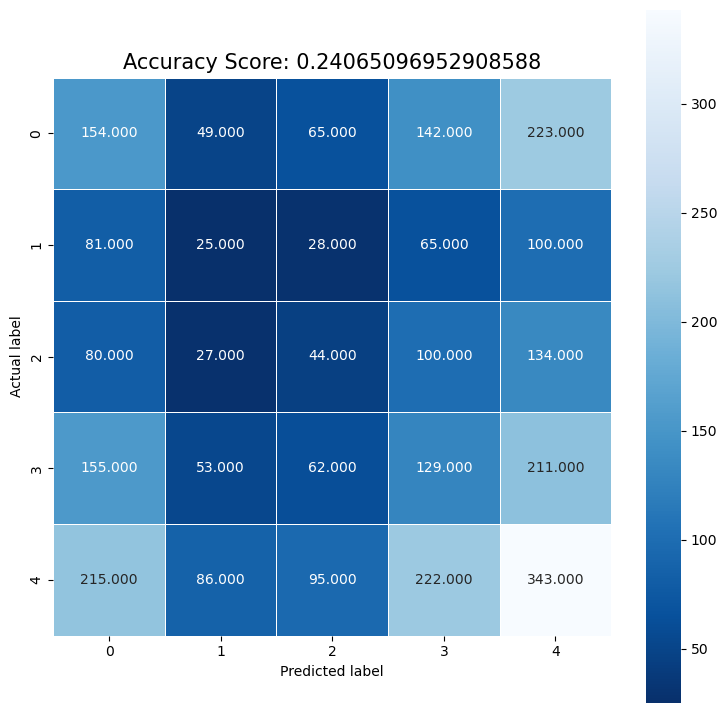

In [42]:
cm = metrics.confusion_matrix(test_df["condition_label"], pred_tfidf)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_1)
plt.title(all_sample_title, size = 15);
plt.savefig("../plots/cm_tfidf.png")

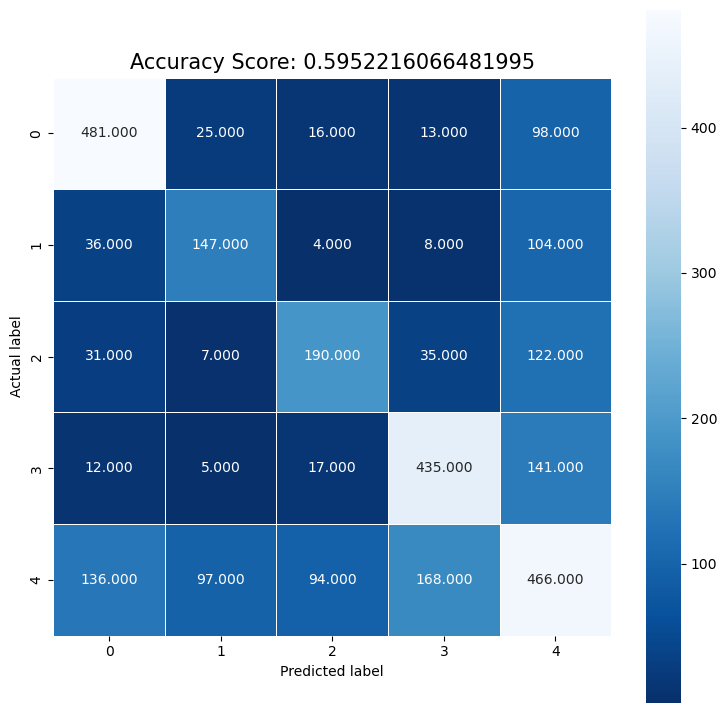

In [43]:
cm = metrics.confusion_matrix(test_df["condition_label"], pred_s2v)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_2)
plt.title(all_sample_title, size = 15);
plt.savefig("../plots/cm_s2v.png")

In [44]:
# Standardizing the TF-IDF features
x_train_tfidf = StandardScaler(with_mean = False).fit_transform(train_lem_tdidf)
x_test_tfidf = StandardScaler(with_mean = False).fit_transform(test_lem_tdidf)

# Standardizing the BioSentVec features
x_train_s2v = StandardScaler().fit_transform(train_lem_vec)
x_test_s2v = StandardScaler().fit_transform(test_lem_vec)

# Define PCA
pca = PCA(n_components = 2)

In [61]:
def plot_PCA(pca_out, pca_fit, conditions, title, dataset_type, out_dir):

    # Create a dataframe to store data before plotting
    pca_df = pd.DataFrame(data = pca_out, columns = ["PC1", "PC2"])

    # Get Explained variance
    exp_var_pca = pca_fit.explained_variance_ratio_

    # Add condition label to df
    if dataset_type == "train":
        # Add Label
        pca_df["condition_name"] = conditions

        # Define a color palette for the conditions
        palette = {
                "neoplasms": "#1f77b4",
                "digestive system diseases": "#ff7f0e",
                "nervous system diseases": "#2ca02c",
                "cardiovascular diseases": "#d62728",
                "general pathological conditions": "#9467bd"
            }

    # Initialize figure
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 

    # Define titles
    ax.set_xlabel(f"Principal Component 1 ({round(exp_var_pca[0]*100, 2)}%)", fontsize = 15)
    ax.set_ylabel(f"Principal Component 2 ({round(exp_var_pca[1]*100, 2)}%)", fontsize = 15)
    ax.set_title(title, fontsize = 20)

    # Plot train
    if dataset_type == "train":
        for condition, color in palette.items():
            indicesToKeep = pca_df["condition_name"] == condition
            ax.scatter(pca_df.loc[indicesToKeep, "PC1"],
                       pca_df.loc[indicesToKeep, "PC2"],
                       c = color,
                       s = 15,
                      alpha = 0.5)
        ax.legend(palette.keys())

    # Plot test
    elif dataset_type == "test":
        ax.scatter(pca_df["PC1"],
                       pca_df["PC2"],
                       s = 15,
                      alpha = 0.5)
    ax.grid()

    plt.savefig(out_dir)

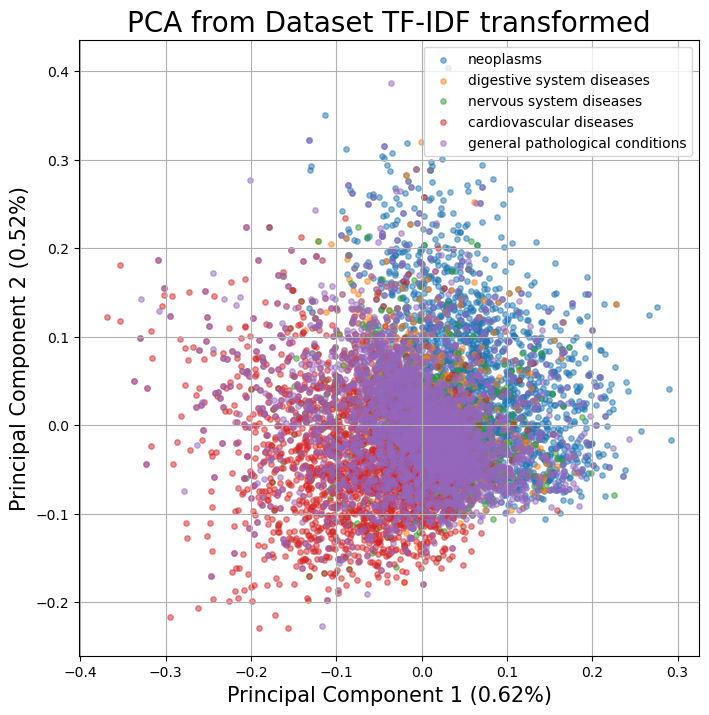

In [65]:
# Principal Components from TF-IDF features
pca_train_tfidf = pca.fit_transform(train_lem_tdidf)
# TF-IDF Train Data
plot_PCA(pca_train_tfidf, pca, train_df["condition_name"], "PCA from Dataset TF-IDF transformed", "train", "../plots/PCA_tfidf.png")

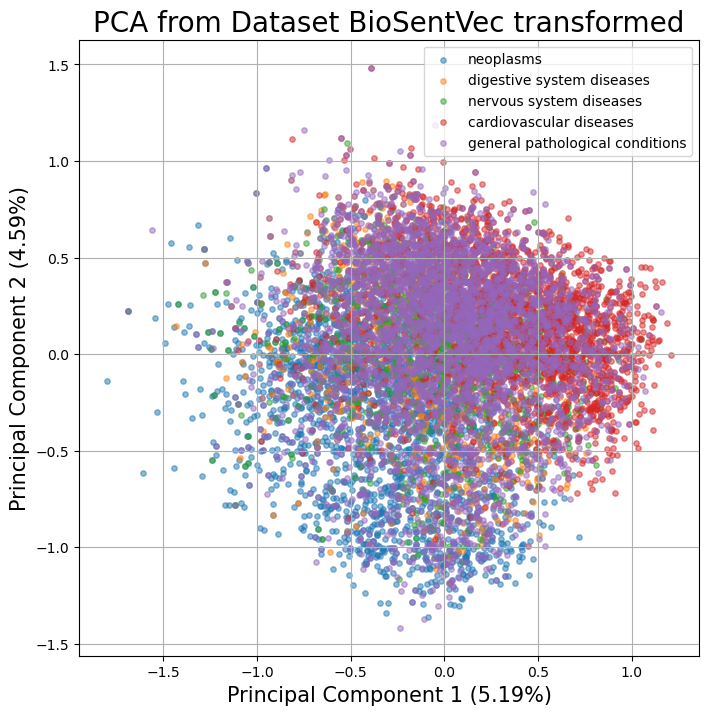

In [64]:
# Principal Components from BioSent2Vec features
pca_train_s2v = pca.fit_transform(train_lem_vec)
# BioSentVec Train Data
plot_PCA(pca_train_s2v, pca, train_df["condition_name"], "PCA from Dataset BioSentVec transformed", "train", "../plots/PCA_s2v.png")

In [54]:
reducer = UMAP(random_state = 777)

In [67]:
def umap_and_plot(data_vec, condition_name, dataset_type, title, out_dir):
    # Initialize the UMAP reducer
    # reducer = UMAP(n_neighbors = 75, min_dist = 0.1, metric = "euclidean")
    
    # Calculate embeddings
    embedding = reducer.fit_transform(data_vec)

    # Show embedding shape
    print(embedding.shape)

    # Define a color palette for the conditions
    palette = {
        "neoplasms": "#1f77b4",
        "digestive system diseases": "#ff7f0e",
        "nervous system diseases": "#2ca02c",
        "cardiovascular diseases": "#d62728",
        "general pathological conditions": "#9467bd"
    }

    # Map conditions to colors
    condition_colors = [palette[condition] for condition in condition_name]
    print(len(condition_colors))

    # Plot
    plt.figure(figsize=(8, 8))
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c = condition_colors,
        s = 10,  # Point size
        alpha = 0.5  # Transparency
    )
    plt.gca().set_aspect("equal", "datalim")
    plt.title(title, fontsize=24)
    plt.xlabel('UMAP1', fontsize=16)
    plt.ylabel('UMAP2', fontsize=16)
    plt.savefig(out_dir)
    plt.show()

(11550, 2)
11550


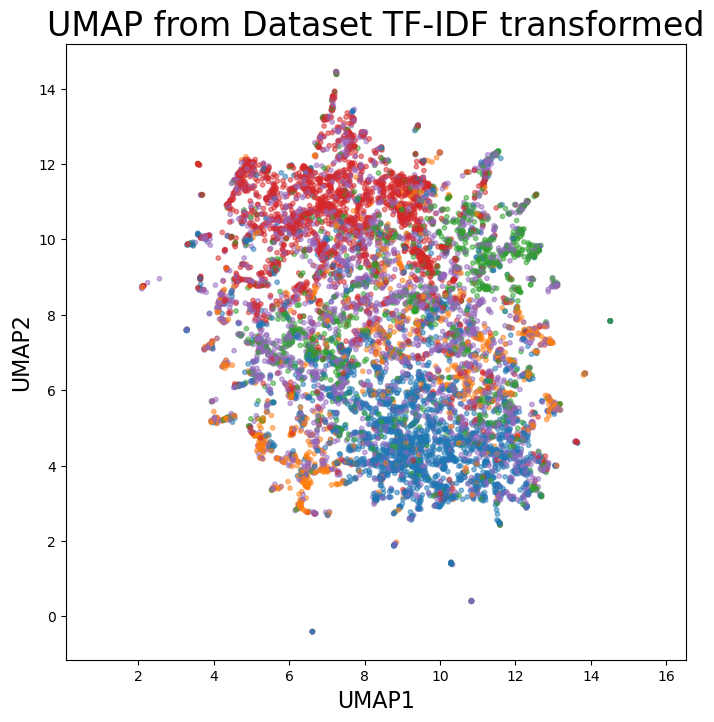

In [68]:
# Train Data TF-IDF transformed
umap_and_plot(train_lem_tdidf, train_df["condition_name"], None, "UMAP from Dataset TF-IDF transformed", "../plots/umap_tfidf.png")

/imppc/labs/lslab/drojas/miniconda3/envs/text_classification/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(11550, 2)
11550


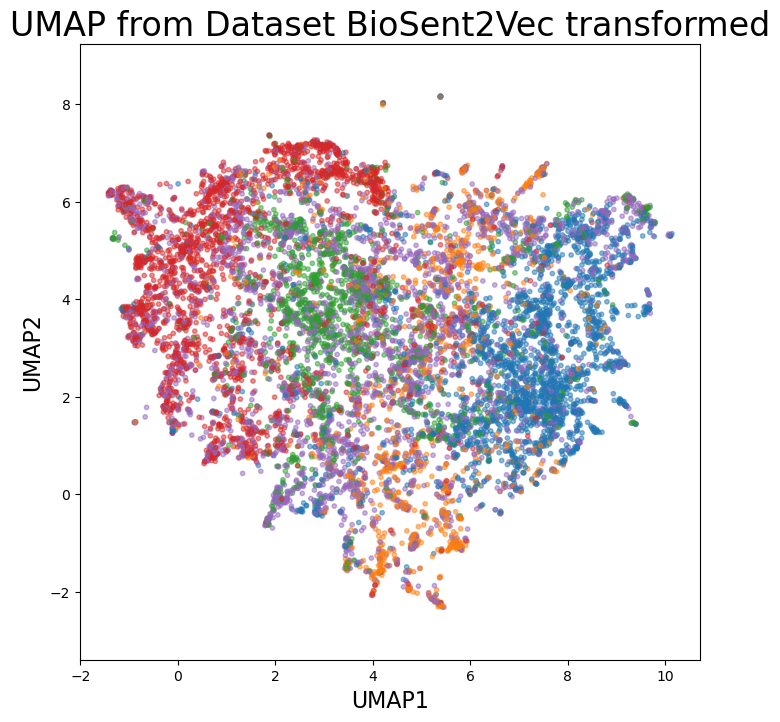

In [70]:
# Train Data TF-IDF transformed
umap_and_plot(train_lem_vec, train_df["condition_name"], None, "UMAP from Dataset BioSent2Vec transformed", "../plots/umap_s2v.png")